![image](google-header.png)

## **Google Search Workbook**

A notebook showcasing how to easily pull Google Search results from Python into easy to use JSON format. Use for exploration, programatic search, or downstream data analysis. The choice is yours!

## **Getting Started**

#### **1.Get API Key**
First check out the following site to get your own Google [API key](https://developers.google.com/custom-search/v1/overview) to enable making requests to the search engine service.

#### **2. Create a Search Engine**
After you have an API key you will need to create a [custom search engine](https://developers.google.com/custom-search/docs/tutorial/creatingcse). Make sure **"Search the entire web"** is enabled in the control panel. If this is not set your search engine will not return any results.

**Search Engine ID** Copy this value from the control panel you will need this value.

#### **3.Set Env Variables**
```bash
export GOOGLE_API_KEY=YOUR_API_KEY
export GOOGLE_SEARCH_ENGINE=SEARCH_ENGINE_ID
export
```

#### **4.Search Google**
```python
# Create Google Client
gc = GoogleSearch(api_key=GOOGLE_API_KEY, 
                  search_engine=GOOGLE_SEARCH_ENGINE)

# Get Results
results = gc.get_results(q='coffee near me')

```

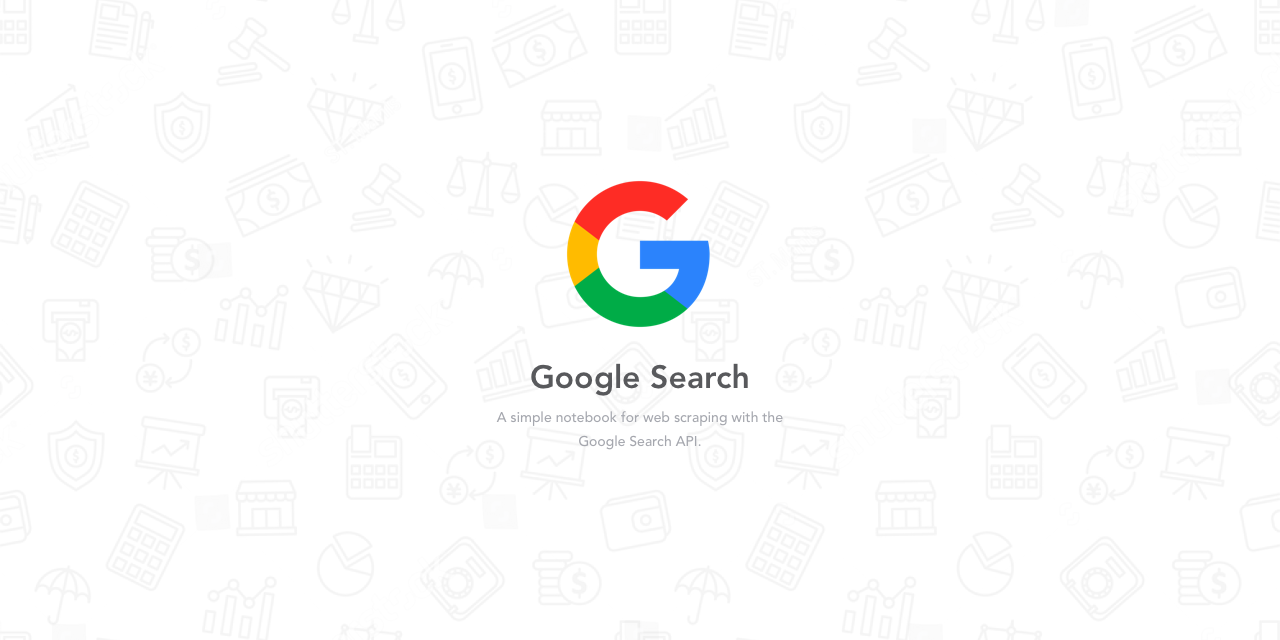

In [2]:
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import os
import json
import pprint as pp
import uuid
import dotenv
from pprint import pprint
from itertools import chain

#### **Configuration**

All Google API Documention can be refered to at the below there are dozens of parameters to further customize search functions **[Google API Reference](https://developers.google.com/custom-search/v1/introduction)**


In [4]:
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GOOGLE_SEARCH_ENGINE = os.getenv('GOOGLE_SEARCH_ENGINE')

RESULTS_PATH = 'data'

#### **Google Search Wrapper**
Creates a wrapper around Google Search API functionality to provide easy to use access to core functionality from the API.

In [5]:
class GoogleSearch:
    '''
    Creates wrapper class around Google Custom API
    that returns JSON response of search result items
    
    Params:
    api_key - String of API key acquired from Google API 
    search_engine - String of custom engine (cx) identifier from console
    '''
    def __init__(self, api_key, search_engine, proxies=None):
        self.api_key = api_key
        self.engine = search_engine
        self.api_url = 'https://www.googleapis.com/customsearch/v1?'
        self.has_next = True
        self.search_stats = None
        self.search_terms = None
        self.proxy = proxies
        
    def get_results(self, **kwargs):
        '''
        Gets the JSON search results meeting
        search criteria
        
        Params:
        kwargs - Any valid key/vlaue combination from Google API
                 https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list
        
        Returns:
        res - JSON response of Google Search Items if any along with additional metadata keys
        
        '''
        
        params = {'key': self.api_key,
                  'cx': self.engine,
                  'start': 1}
        
        for key, value in kwargs.items():
            params[key] = value
        
        results = []
        
        while self.has_next == True:
            if self.proxies:
                res = requests.get(self.api_url, params=params, proxies=self.proxies)
            else:
                res = requests.get(self.api_url, params=params)
            res = res.json()
            
            # Get results from search
            try:
                search_results = res['items']
                results.append(search_results)
            except:
                pass
            
            if params['start'] == 1:
                self.search_stats = res['searchInformation']
                self.search_terms = res['queries']['request'][0]
            try:
                params['start'] = res['queries']['nextPage'][0]['startIndex']
            except:
                self.has_next = False
        
        return list(chain(*results))

#### **Create Google Client**

In [7]:
# Create Google Client
gc = GoogleSearch(api_key=GOOGLE_API_KEY, search_engine=GOOGLE_SEARCH_ENGINE)

# Search Results
search_results = gc.get_results(q='covid-19 vaccines')

print(f'{len(search_results)} Google Results Returned...')

100 Google Results Returned...


#### **View Metadata**

In [8]:
search_stats = gc.search_stats
search_terms = gc.search_terms
print(search_stats)
print(search_terms['searchTerms'])

{'searchTime': 0.445084, 'formattedSearchTime': '0.45', 'totalResults': '173000000', 'formattedTotalResults': '173,000,000'}
covid-19 vaccines


#### **Data Cleanup**
##### **Search Results Dataframe**

In [9]:
search_df = pd.DataFrame(search_results)
search_df.drop(columns=['kind', 'htmlTitle', 'htmlSnippet', 'htmlFormattedUrl'], inplace=True)
search_df.head()

,title,link,displayLink,snippet,cacheId,formattedUrl,pagemap
0,Where We're at with Vaccines and Treatments fo...,https://www.healthline.com/health-news/heres-e...,www.healthline.com,3 days ago ... Scientists around the world are...,3ipdFSvg4JEJ,https://www.healthline.com/.../heres-exactly-w...,{'cse_thumbnail': [{'src': 'https://encrypted-...
1,Pfizer: COVID-19 Vaccine Could Arrive in October,https://www.webmd.com/lung/news/20200515/pfize...,www.webmd.com,"May 15, 2020 ... Pharmaceutical company Pfizer...",x2ZnEeIQudkJ,https://www.webmd.com/.../pfizer-says-covid-19...,{'cse_thumbnail': [{'src': 'https://encrypted-...
2,What you need to know about the COVID-19 vacci...,https://www.gatesnotes.com/Health/What-you-nee...,www.gatesnotes.com,"Apr 30, 2020 ... How do you store it? Many com...",NaN,https://www.gatesnotes.com/.../What-you-need-t...,{'cse_thumbnail': [{'src': 'https://encrypted-...
3,COVID-19 vaccine tracker | RAPS,https://www.raps.org/news-and-articles/news-ar...,www.raps.org,This tracker lists COVID-19 vaccine candidates...,sB1XCTgmPtsJ,https://www.raps.org/news-and-articles/news......,{'cse_thumbnail': [{'src': 'https://encrypted-...
4,Trump unveils audacious plan to develop Covid-...,https://www.statnews.com/2020/05/15/trump-auda...,www.statnews.com,"May 15, 2020 ... Trump administration outlines...",lGEf1Nfgz0oJ,https://www.statnews.com/2020/05/.../trump-aud...,"{'hcard': [{'fn': 'Dan', 'nickname': 'Dan'}, {..."


#### **Search Term Data Frame**

In [10]:
search_terms_df = pd.DataFrame(search_terms, index=[0])
search_terms_df.drop(columns=['count', 'startIndex', 'inputEncoding', 'outputEncoding','safe', 'cx'], inplace=True)
search_terms_df.head()

,title,totalResults,searchTerms
0,Google Custom Search - covid-19 vaccines,173000000,covid-19 vaccines


#### **Export Data**

In [11]:
# Save As Tab Delimited Files
search_df.to_csv(Path(RESULTS_PATH).joinpath('search_results.csv'), sep='\t', index=False)
search_terms_df.to_csv(Path(RESULTS_PATH).joinpath('search_terms.csv'), sep='\t', index=False)

### **Download Data**
Create functionality to download the files from a link and save to local storage for downstream analyics and data mining.

In [14]:
def _create_file_name(file_url):
    '''
    Creates a unique filename for a given file
    
    Params:
    file_url - string of valid file url
    
    Returns:
    filename - string of unique filename
    '''
    
    filetype = Path(file_url).suffix
    
    if filetype == '':
        filetype = '.html'
    else:
        filetype
        
    filename = str(uuid.uuid4()) + filetype
    
    return filename

def get_file(file_url, dest=None):
    '''
    Downloads file from the internet and optionally
    saves to location on local machine.
    
    Params:
    file_url - string of valid path to download from
    dest - string of path to save file to. (Default: Current working directory)
    
    Returns:
    status - If successful returns 1 else 0
    '''
    file = requests.get(file_url)
    
    fname = _create_file_name(file_url)
    
    if dest:
        dest = Path(dest).joinpath(fname)
    else:
        dest = fname
    
    with open(dest, 'wb') as f:
        f.write(file.content)
        f.close()
        return 'Success'

##### **Test Download Functionality**
Grab first 5 links and download locally for further analysis.

In [15]:
test_links = search_df['link'][0:5]

[get_file(link, 'downloads') for link in test_links]

['Success', 'Success', 'Success', 'Success', 'Success']